In [1]:
import util
from difference_models import BinaryDifferenceClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import shap
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

In [2]:
try:
    with open('dataset.pickle', 'rb') as f:
        X, y, display_data, feature_names, n_features, n_samples = pickle.load(f)
        print('Loaded cached dataset')
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


## Load Data

In [16]:
X, y = shap.datasets.adult()
feature_names = np.array(X.columns)
X = X.values
display_data = shap.datasets.adult(display=True)[0].values
n_features = len(feature_names)
n_samples = X.shape[0]
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, display_data, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

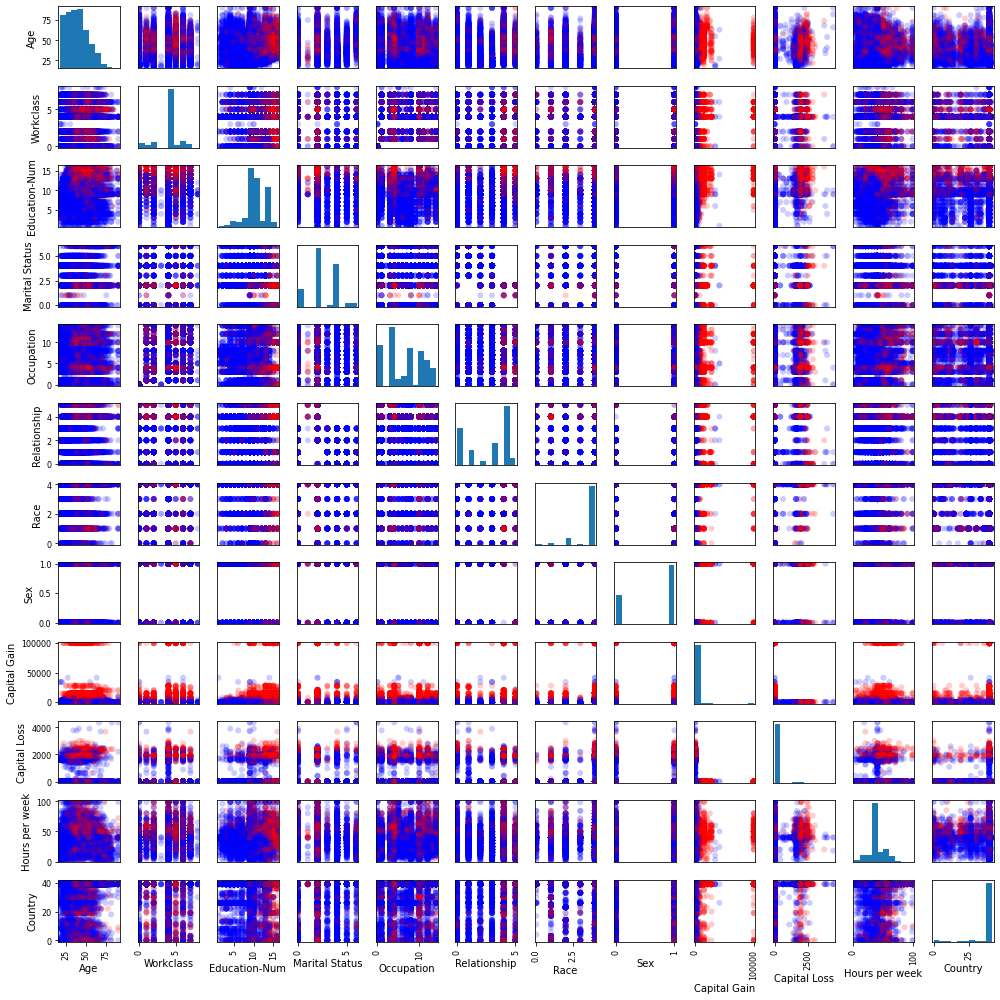

In [44]:
df = pd.DataFrame(X, columns=feature_names)
axes = pd.plotting.scatter_matrix(df, figsize=(14, 14), marker='o', alpha=0.2, c=['r' if y_ else 'b' for y_ in y])
plt.tight_layout()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=52)

## Train Models

TODO: https://scikit-learn.org/stable/modules/calibration.html

In [52]:
%%time
clf_a = LogisticRegression(C=1.0, max_iter=10000)
clf_a.fit(X_train, y_train)
clf_b = deepcopy(clf_a)
clf_b.intercept_ -= 2e-1
clf_b.coef_[:, 0] += 2e-3
clf_b.coef_[:, 2] += 2e-2
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 13.1 s, sys: 1.11 s, total: 14.2 s
Wall time: 7.97 s


## Analyze Performance

In [53]:
pred_test_a = clf_a.predict(X_test)
pred_test_b = clf_b.predict(X_test)

In [54]:
print(classification_report(pred_test_a, y_test))

              precision    recall  f1-score   support

       False       0.94      0.87      0.90      5364
        True       0.54      0.73      0.62      1149

    accuracy                           0.84      6513
   macro avg       0.74      0.80      0.76      6513
weighted avg       0.87      0.84      0.85      6513



In [55]:
print(classification_report(pred_test_b, y_test))

              precision    recall  f1-score   support

       False       0.93      0.87      0.90      5275
        True       0.57      0.72      0.63      1238

    accuracy                           0.84      6513
   macro avg       0.75      0.79      0.77      6513
weighted avg       0.86      0.84      0.85      6513



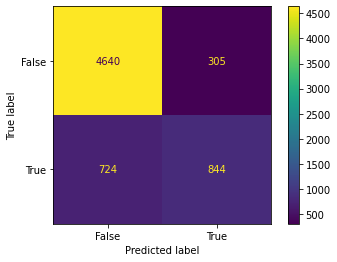

In [56]:
cm = confusion_matrix(y_test, pred_test_a, labels=clf_a.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_a.classes_)
disp.plot();

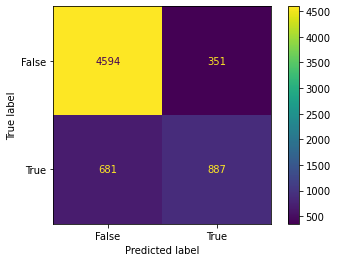

In [57]:
cm = confusion_matrix(y_test, pred_test_b, labels=clf_b.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_b.classes_)
disp.plot();

In [58]:
proba_test_a = clf_a.predict_proba(X_test)[:, 1]
proba_test_b = clf_b.predict_proba(X_test)[:, 1]
fpr_a, tpr_a, _ = roc_curve(y_test, proba_test_a)
fpr_b, tpr_b, _ = roc_curve(y_test, proba_test_b)

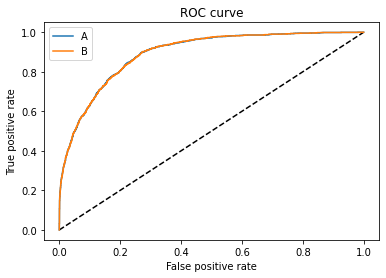

In [59]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_a, tpr_a, label='A')
plt.plot(fpr_b, tpr_b, label='B')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [60]:
roc_auc_score(y_test, proba_test_a)

0.8920452141928562

In [61]:
roc_auc_score(y_test, proba_test_b)

0.8920523075256392

## Visualize Distributions of Predictions

In [62]:
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = clf_b.predict_log_proba(X)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

is_finite = np.isfinite(log_odds_a) & np.isfinite(log_odds_b)
X_clean = X[is_finite]
display_data_clean = display_data[is_finite]

n_samples_clean = X_clean.shape[0]
indices = np.array(range(n_samples_clean))
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
proba_a = clf_a.predict_proba(X)
proba_b = clf_b.predict_proba(X)
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = clf_b.predict_log_proba(X)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

with open('predictions.pickle', 'wb') as f:
    pickle.dump((X_clean, display_data_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b), f, pickle.HIGHEST_PROTOCOL)

Instances with non-finite log-odds predictions:

In [63]:
pd.DataFrame(X[~is_finite]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


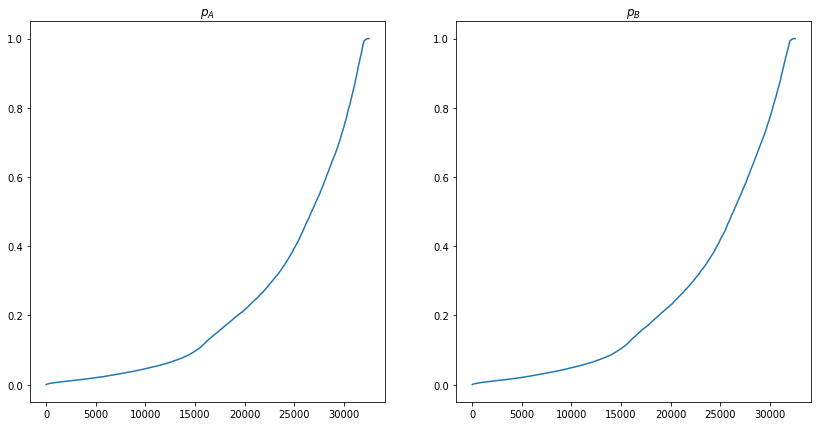

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(sorted(proba_a[:, 1]))
ax2.set_title('$p_B$')
ax2.plot(sorted(proba_b[:, 1]));

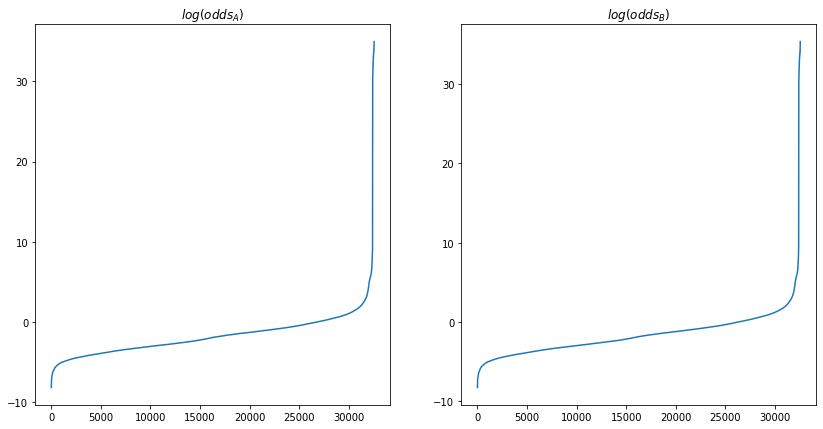

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(sorted(log_odds_a))
ax2.set_title('$log(odds_B)$')
ax2.plot(sorted(log_odds_b));

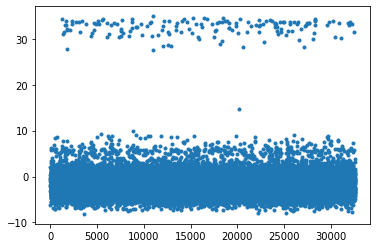

In [66]:
plt.scatter(indices, log_odds_a, marker='.');

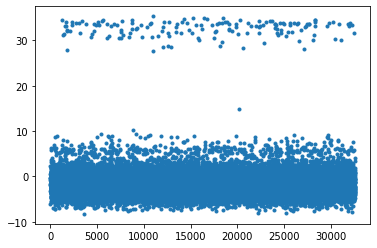

In [67]:
plt.scatter(indices, log_odds_b, marker='.');